In [137]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import math

## Parameters

In [138]:
# files_path = r"C:\Users\chiss\__WISH\_KMITL\ComputerVision\_Project\dataset"
# destination_path = r"C:\Users\chiss\__WISH\_KMITL\ComputerVision\_Project\dataset\result"

files_path = r'D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset'
destination_path = r'D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\result'
multiplier = 0.95

## Inspection Function

In [139]:
def find_pingpong(frame):
    summary = []
    qualify = 0
    img = cv2.imread(frame)
    img = cv2.resize(img, None, fx=0.2, fy=0.2)
    print('-------------------------------| file:', frame)
    
    
    ## ------ Image Proparation
    HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Get white mask (pinpong ball colour mask)
    lower = np.array([0, 0, 130])
    upper = np.array([40,80, 255])
    white_mask = cv2.inRange(HSV_img, lower, upper)
    out = cv2.bitwise_and(img, img, mask = white_mask)
    img_res = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, np.ones((9, 9)), iterations= 2)


    ## ------ Significant Roundness Detection
    circles = cv2.HoughCircles(img_res, cv2.HOUGH_GRADIENT,
                           dp= 0.8, minDist= 200,
                           param1= 10, param2= 10, 
                           minRadius= 112, maxRadius= 130)
    
    # Can't fit circle
    if circles is None:
        summary = ["Significant not round", "-", "-"]
        return None, summary , qualify
        
    img_rgb = img.copy()
    pingPong = (0, 0, 0)
    img_rgb = img.copy()
    pingPong = (0, 0, 0)
    X,Y,R = 0,0,0
    for x, y, r in circles[0]:
        if r > R:
            X,Y,R = x, y, r
    cv2.circle(img_rgb, (int(X), int(Y)), int(R), (255, 0, 0), thickness= 5)
    cv2.circle(img_rgb, (int(X), int(Y)), 5, (255, 0, 0), thickness= -1)
        
    pingPong = ((int(X), int(Y)), int(R))
    print('R:', pingPong)


    ## ------ Crop Out Background
    mask = np.zeros(img.shape, dtype=np.uint8) 
    cv2.circle(mask, pingPong[0], pingPong[1], (255,255,255), thickness=-1)  
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    img_pingpong = cv2.bitwise_and(img, img, mask=mask)
    img_pingpong_cropped = cv2.getRectSubPix(img_pingpong, (pingPong[1]*2+20, pingPong[1]*2+20), pingPong[0])
    img_pingpong_cropped_gray = cv2.cvtColor(img_pingpong_cropped, cv2.COLOR_BGR2GRAY)


    ## ------ Roundness Detection
    _,tsh = cv2.threshold(img_pingpong_cropped_gray, 130, 255, cv2.THRESH_BINARY)
    tsh = cv2.morphologyEx(tsh, cv2.MORPH_CLOSE, np.ones((5, 5)), iterations= 2)
    
    contour, H = cv2.findContours(tsh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contourArea = []
    imgTest = img_pingpong_cropped.copy()
    for i in range(len(contour)):
        area = cv2.contourArea(contour[i])
        print("index", i, "\tContourArea", area)
        contourArea.append(area)
        
    # Calculate contour area
    max_contour_area = max(contourArea)
    max_contour_index = contourArea.index(max_contour_area)
    cv2.drawContours(imgTest, contour, max_contour_index, (255,0,0), thickness = -1)
    
    # Calculate Hough Circle area
    conditionArea = multiplier*(math.pi * ((pingPong[1])**2))
    
    print(f"Condition the area: {conditionArea} ")
    print(f"Contur Area: {max_contour_area}")
    if area < conditionArea:
        print("Not round")
        summary.append("NOT round")
    else:
        print("pass")
        summary.append("round")
        qualify += 1
    summary.append(str(max_contour_area))
    
    
    ## ------ Filter Branding Text
    text_edge = cv2.Canny(img_pingpong_cropped, 20, 220)
    edge = cv2.Canny(img_pingpong_cropped, 30, 100)
    defects = cv2.bitwise_xor(edge, text_edge)


    ## ------ Defection Detection
    defects_connect = cv2.morphologyEx(defects, cv2.MORPH_CLOSE, np.ones((9, 9)), iterations= 2)
    contours_9, _ = cv2.findContours(defects, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # If length over the threshold, draw the bounding contour 
    img_contour = img_pingpong_cropped.copy()
    n_defect = 0
    for contour in contours_9:
        arc_length = cv2.arcLength(contour, True)
        
        # print(arc_length)
        if arc_length > 100:
            cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 3)
            n_defect+= 1
        # if cv2.arcLength(contour, True)
    
    
    ## ------ Conclude
    if n_defect != 0:
        print('found defection')
        summary.append("DEFECTED")
    else:
        print('not found')
        summary.append("no defection")
        qualify += 1
    img_list = [img_pingpong_cropped, imgTest, text_edge, edge, defects, defects_connect,  img_contour]
    img_list_rgb = []
    for image in img_list:
        # print(image.shape)
        if len(image.shape) < 3:
            imgPREP = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            # imgPREP = image[:,:, ::-1]
            imgPREP = image
        img_list_rgb.append(imgPREP)
        
    result = cv2.hconcat(img_list_rgb)
    # plt.imshow(result)
    return result, summary, qualify

## Main Run

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset/IMG_5062.jpg
R: ((300, 431), 113)
index 0 	ContourArea 39053.5
Condition the area: 38109.24676400366 
Contur Area: 39053.5
pass
not found

<---- Result ---->
Pass qualification: 2
Summary: ['round', '39053.5', 'no defection']


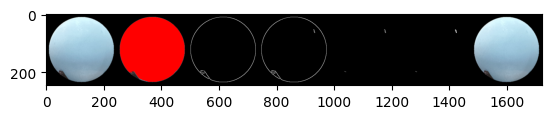

In [140]:
# Single Shot
sample_img_path = files_path + '/IMG_5062.jpg'
res, summary, qualify = find_pingpong(sample_img_path)

print('\n<---- Result ---->\nPass qualification:', qualify)
print('Summary:', summary)

plt.imshow(res)

  5%|▌         | 1/19 [00:00<00:02,  6.50it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5062.JPG
R: ((300, 431), 113)
index 0 	ContourArea 39053.5
Condition the area: 38109.24676400366 
Contur Area: 39053.5
pass
not found
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5063.JPG
R: ((302, 434), 114)
index 0 	ContourArea 39335.5
Condition the area: 38786.731219750305 
Contur Area: 39335.5
pass
not found


 21%|██        | 4/19 [00:00<00:02,  6.61it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5064.JPG
R: ((303, 432), 113)
index 0 	ContourArea 38857.0
Condition the area: 38109.24676400366 
Contur Area: 38857.0
pass
not found
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5065.JPG
R: ((299, 432), 113)
index 0 	ContourArea 38841.5
Condition the area: 38109.24676400366 
Contur Area: 38841.5
pass
not found


 32%|███▏      | 6/19 [00:00<00:02,  6.40it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5066.JPG
R: ((301, 434), 115)
index 0 	ContourArea 39725.5
Condition the area: 39470.18470153876 
Contur Area: 39725.5
pass
not found
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5067.JPG
R: ((300, 430), 113)
index 0 	ContourArea 38950.0
Condition the area: 38109.24676400366 
Contur Area: 38950.0
pass
found defection


 42%|████▏     | 8/19 [00:01<00:01,  6.37it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5068.JPG
R: ((299, 432), 113)
index 0 	ContourArea 0.0
index 1 	ContourArea 38860.0
Condition the area: 38109.24676400366 
Contur Area: 38860.0
pass
found defection
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5069.JPG
R: ((299, 433), 115)
index 0 	ContourArea 0.0
index 1 	ContourArea 38120.0
Condition the area: 39470.18470153876 
Contur Area: 38120.0
Not round
not found


 47%|████▋     | 9/19 [00:01<00:01,  6.17it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5070.JPG
R: ((300, 430), 113)
index 0 	ContourArea 38964.0
Condition the area: 38109.24676400366 
Contur Area: 38964.0
pass
found defection
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5071.JPG
R: ((290, 430), 114)
index 0 	ContourArea 38459.5
Condition the area: 38786.731219750305 
Contur Area: 38459.5
Not round


 58%|█████▊    | 11/19 [00:01<00:01,  6.22it/s]

not found
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5072.JPG
R: ((299, 431), 113)
index 0 	ContourArea 38750.0
Condition the area: 38109.24676400366 
Contur Area: 38750.0
pass
found defection


 68%|██████▊   | 13/19 [00:02<00:00,  6.18it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5073.JPG
R: ((289, 437), 116)
index 0 	ContourArea 36466.5
Condition the area: 40159.60720936904 
Contur Area: 36466.5
Not round
not found
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5074.JPG
R: ((298, 429), 112)
index 0 	ContourArea 0.5
index 1 	ContourArea 38255.0
Condition the area: 37437.73133429884 
Contur Area: 38255.0
pass
found defection


 79%|███████▉  | 15/19 [00:02<00:00,  6.24it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5075.JPG
R: ((300, 426), 113)
index 0 	ContourArea 37715.0
Condition the area: 38109.24676400366 
Contur Area: 37715.0
Not round
found defection
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5076.jpg


 89%|████████▉ | 17/19 [00:02<00:00,  6.36it/s]

-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5077.jpg
-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5078.jpg


100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


-------------------------------| file: D:\KMITL\KMITL\Year 02 - 02\Computer Vision\Work\A02_17_2024_Project\V2\dataset\IMG_5079.jpg
error


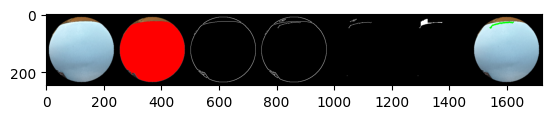

In [141]:
# Multiple data
data_log = []
for file in tqdm(os.listdir(files_path)):
    f = os.path.join(files_path, file)
    
    try:
        out, summary, qualify = find_pingpong(f)
    except:
        print('error')
        continue
    
    if qualify == 2:
        data_log.append([file] + summary + ["QUALIFY"])
    else:
        data_log.append([file] + summary + ["REJECT"])
    
    if out is not None:
        cv2.imwrite(os.path.join(destination_path, file), out)
        plt.imshow(out)
    
# Save data to CSV      
df = pd.DataFrame(data_log, columns=["Image_Name", "Roundness", "Contour Area", "Defection", "Status"])
df.to_csv(os.path.join(destination_path, "dataLOG.csv"))